In [29]:
import torch
from torchvision import datasets, transforms
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [30]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [31]:
model = Classifier()
images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [32]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])
#k value and indices
#.topk

tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7]])


In [33]:
print(labels.shape)
equals = top_class == labels.view(*top_class.shape)
print(equals.shape)
print(top_class.shape)

torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 1])


In [39]:
equals[11]

tensor([True])

In [40]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 3.125%


In [42]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/5..  Training Loss: 0.517..  Test Loss: 0.455..  Test Accuracy: 0.834
Epoch: 2/5..  Training Loss: 0.391..  Test Loss: 0.408..  Test Accuracy: 0.857
Epoch: 3/5..  Training Loss: 0.352..  Test Loss: 0.411..  Test Accuracy: 0.853
Epoch: 4/5..  Training Loss: 0.329..  Test Loss: 0.405..  Test Accuracy: 0.856
Epoch: 5/5..  Training Loss: 0.315..  Test Loss: 0.374..  Test Accuracy: 0.866


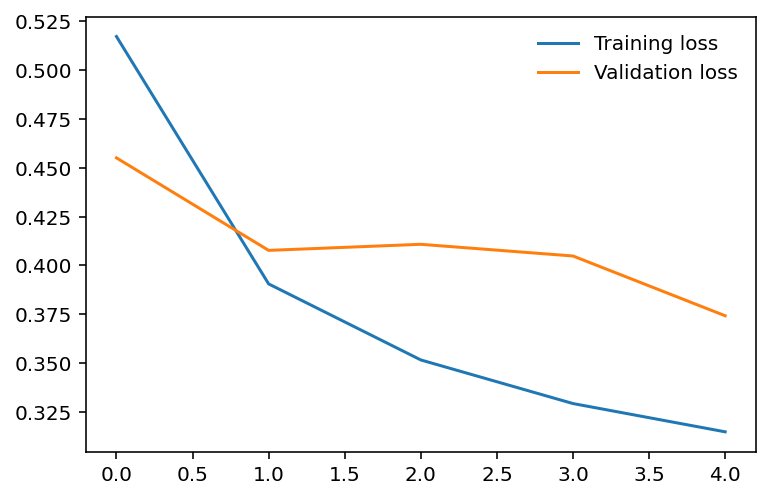

In [44]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)